In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [6]:
  data = pd.read_csv('~/Downloads/Samsung_Dataset.csv')

In [7]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.709961,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.859863,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.098145,46880000


In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [9]:
data_pivot = data.pivot_table(index='Date', values=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], aggfunc='mean')
data_pivot.reset_index(inplace=True)
data_pivot.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2000-01-04,4449.709961,6110.0,6110.0,5660.0,6000.0,74195000.0
1,2000-01-05,4063.728760,5580.0,6060.0,5520.0,5800.0,74680000.0
2,2000-01-06,4092.859863,5620.0,5780.0,5580.0,5750.0,54390000.0
3,2000-01-07,4034.598877,5540.0,5670.0,5360.0,5560.0,40305000.0
4,2000-01-10,4202.098145,5770.0,5770.0,5580.0,5600.0,46880000.0


In [11]:
df = data_pivot

In [12]:
df['MA_20'] = df['Close'].rolling(window=20).mean()

In [13]:
df['MA_200'] = df['Close'].rolling(window=200).mean()

In [14]:
def RSI(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    ema_gain = gain.ewm(com=period - 1, adjust=False).mean()
    ema_loss = loss.ewm(com=period - 1, adjust=False).mean()
    RS = ema_gain / ema_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI_14'] = RSI(df, period=14)

In [15]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,MA_20,MA_200,RSI_14
0,2000-01-04,4449.709961,6110.0,6110.0,5660.0,6000.0,74195000.0,NaN,NaN,NaN
1,2000-01-05,4063.728760,5580.0,6060.0,5520.0,5800.0,74680000.0,NaN,NaN,0.000000
2,2000-01-06,4092.859863,5620.0,5780.0,5580.0,5750.0,54390000.0,NaN,NaN,7.516779
3,2000-01-07,4034.598877,5540.0,5670.0,5360.0,5560.0,40305000.0,NaN,NaN,6.469386
4,2000-01-10,4202.098145,5770.0,5770.0,5580.0,5600.0,46880000.0,NaN,NaN,34.658860


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
df['MA_20'] = imputer.fit_transform(df[['MA_20']])
df['MA_200'] = imputer.fit_transform(df[['MA_200']])
df['RSI_14'] = imputer.fit_transform(df[['RSI_14']])

In [19]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,MA_20,MA_200,RSI_14
0,2000-01-04,4449.709961,6110.0,6110.0,5660.0,6000.0,74195000.0,0.0,0.0,0.000000
1,2000-01-05,4063.728760,5580.0,6060.0,5520.0,5800.0,74680000.0,0.0,0.0,0.000000
2,2000-01-06,4092.859863,5620.0,5780.0,5580.0,5750.0,54390000.0,0.0,0.0,7.516779
3,2000-01-07,4034.598877,5540.0,5670.0,5360.0,5560.0,40305000.0,0.0,0.0,6.469386
4,2000-01-10,4202.098145,5770.0,5770.0,5580.0,5600.0,46880000.0,0.0,0.0,34.658860


In [21]:
# prompt: minmax scaler without Date columns

scaler = MinMaxScaler()
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA_20', 'MA_200', 'RSI_14']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
X = df.drop()

In [44]:
X = df.drop(['Date','Close'], axis=1)
y = df['Close']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [61]:
y_test.tail()

6122    0.844794
6123    0.826668
6124    0.821004
6125    0.835731
6126    0.859522
Name: Close, dtype: float64

In [48]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], 8, 1))
X_test_reshaped = X_test_np.reshape((X_test_np.shape[0], 8, 1))


In [49]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(8, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [51]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=60, verbose=1)


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0131 - val_loss: 0.0060
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6356e-04 - val_loss: 0.0012
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1263e-04 - val_loss: 2.6242e-04
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5941e-04 - val_loss: 4.0724e-04
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5351e-04 - val_loss: 4.4127e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3212e-04 - val_loss: 6.8505e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1869e-04 - val_loss: 7.1778e-04
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5727e-05 - val_loss: 8.5062e-04
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6106e-05 - val_loss: 0.0018
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4629e-05 - val_loss: 7.5819e-04
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9879e-05 - val_loss: 0.

In [52]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

In [53]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [56]:
train_rmse = math.sqrt(mean_squared_error(y_train,
train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 0.0022579749691764885, Test RMSE: 0.043153799011359066


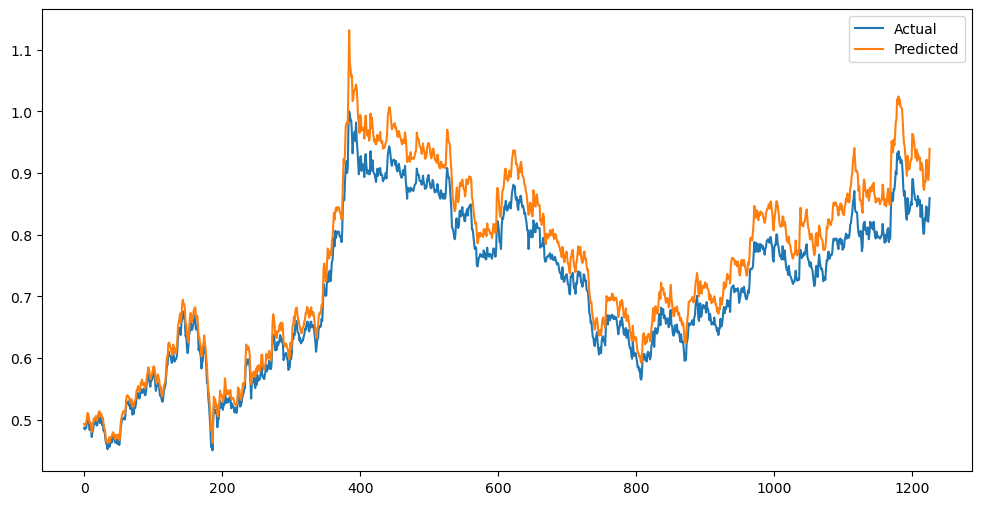

In [63]:
plt.figure(figsize=(12,6))
y_test.reset_index(drop=True, inplace=True)
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.show()